# Цели и задачи исследования

Bridge to Moscow (https://bridgetomoscow.com)- туристический портал, предлагающий экскурсионные программы для иностранных клиентов.

Задача исследования - изучить поведение клиентов и проанализировать, какие категории клиентов приносят больше прибыли для компании. Мы изучим показатели конверсии по разным странам, а также метрики ARPU и ARPPU.

Мы также изучим динамику роста прибыли и проанализируем, есть ли явно выраженные сезонные колебания.

Дополнительно нам интересно изучить, за какой период люди из разных стран начинают планировать свои путешествия.

В процессе исследования мы также изучим самые популярные страницы сайта. Нам необходимо выявить те страницы, по которым клиенты чаще совершают бронирования, а также найти те туры, по которым у компании самые высокие показатели отказов.

Мы изучал поведение клиентов за период с 2017 по 2019 год. В последние годы  рынок туристических услуг сильно изменился, и поведение клиентов  нам не представляется предсказуемым.


## 1.Загрузка библиотек

In [1]:
import pandas as pd
import re
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from pandas.core.arrays.categorical import contains

## 2.Обзор данных

In [2]:
raw = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/xY0DXQbL1w039A')
raw.head(3)

,Unnamed: 0,source,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_choice,citizenship,coming_date,other_request,request_time,id
0,0,http://bridgetomoscow.com/feedback,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hi,&#10;I am interested in a 3-4 hour guided t...",2017-02-11 09:03:38,694
1,1,http://bridgetomoscow.com/dogsledging-in-the-m...,NaN,522,NaN,NaN,NaN,NaN,USA,currently in Moscow,Will you be offering the dog sledding trip aga...,2017-02-11 16:41:38,3508
2,2,http://bridgetomoscow.com/driving-tour-of-moscow,English,NaN,2.0,1.0,0.0,NaN,NaN,NaN,<br>,2017-02-11 17:48:56,2748


In [3]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/QVwkN_0sN-o-AA')
df.head(3)

,Unnamed: 0,id,order_year,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_cost,page,request_time,citizenship,year,month,date,tour days,city,revenue
0,0,3,2017,English,NaN,1.0,0.0,0.0,7050.0,walking-tour-of-moscow,2017-03-14 22:24:16,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1775,2017,NaN,1,NaN,NaN,NaN,0.0,/dogsledging-in-the-moscow-countryside,2017-09-05 15:26:53,Swiss,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1785,2017,NaN,3,NaN,NaN,NaN,0.0,customized-tours,2017-06-22 17:34:09,Dutch,2017.0,7.0,4.0,1.0,0,1247.0


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6197 entries, 0 to 6196
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6197 non-null   int64  
 1   source             6197 non-null   object 
 2   language           583 non-null    object 
 3   travellers_number  4312 non-null   object 
 4   travellers_adults  583 non-null    float64
 5   travellers_teens   583 non-null    float64
 6   travellers_babies  583 non-null    float64
 7   tour_choice        212 non-null    object 
 8   citizenship        2886 non-null   object 
 9   coming_date        2882 non-null   object 
 10  other_request      6191 non-null   object 
 11  request_time       6197 non-null   object 
 12  id                 6197 non-null   int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 629.5+ KB


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2730 non-null   int64  
 1   id                 2730 non-null   int64  
 2   order_year         2730 non-null   int64  
 3   language           445 non-null    object 
 4   travellers_number  1637 non-null   object 
 5   travellers_adults  445 non-null    float64
 6   travellers_teens   445 non-null    float64
 7   travellers_babies  445 non-null    float64
 8   tour_cost          2730 non-null   float64
 9   page               2730 non-null   object 
 10  request_time       2730 non-null   object 
 11  citizenship        1927 non-null   object 
 12  year               601 non-null    float64
 13  month              601 non-null    float64
 14  date               601 non-null    float64
 15  tour days          601 non-null    float64
 16  city               601 n

В нашем распоряжени 2 датасета:

Датасет raw - заявки клиентов на сайте, собранные в период с 2017 по 2023 год. Мы будем изучать не все входящие заявки компании, а лишь те, которые поступали через форму заказов. В нашем исследовании мы ограничимся периодом с 2017 по 2019. Данные прошли первоначальную (скрытую) предобработку, где были скрыты все персональные данные клиентов.

Датасет df - объединенный датасет из первоначальных двух (заказы сайта и подтвержденные бронирования). Мы первоначально объединили данные не по id, а по email клиентов, но в настоящем исследовании мы будем уже работать с объединенным датафреймом, в которым мы также изменили персональные данные, а также преобразовали колонку revenue (настоящие цифры отличаются от исходных на некий коэффициент)


## 3.Предобработка данных

В колонках 'language','citizenship', 'page' датафрейма df, а также в датафрейме raw 'language','citizenship', 'coming_date'заменим пропущенные значения на 'unknown'

In [9]:
df[['language','citizenship', 'page']] = df[['language','citizenship', 'page']].fillna('unknown')
raw[['language','citizenship', 'coming_date']] = raw[['language','citizenship', 'coming_date']].fillna('unknown')


Преобразуем время заявки в формат времени

In [10]:
df['request_time'] = pd.to_datetime(df['request_time'])
raw['request_time'] = pd.to_datetime(raw['request_time'])
raw['year'] = raw['request_time'].dt.year
raw['coming_date'] = raw['coming_date'].str.lower()

В датафрейме слишком много вариантов написания стран. Создадим словарь и упорядочим варианты написания

In [11]:
df['citizenship'] = df['citizenship'].str.lower()
raw['citizenship'] = raw['citizenship'].str.lower()

In [12]:
def change_data1(entry):
  if 'and' in entry:
    return 'mixed'
  if ',' in entry:
    return 'mixed'
  if '/' in entry:
    return 'mixed'
  if '-' in entry:
    return 'mixed'
  else:
    return entry.strip()

In [13]:
df['citizenship'] = df['citizenship'].apply(change_data1)
raw['citizenship'] = raw['citizenship'].apply(change_data1)

In [26]:
country_mapping = {
'unknown': ['out african', 'la','hksar','t','qdd','perгє','ph','schweizerin', 'out afranceican','old',
            'rsa','nil','monter?a', 'yes', 'дњeskгў republika','й¦™жёї', 'feitsch', 'family','ch',
             '0','0974','1', '???', '?sterreich','at', 'aus'],
'mixed': ['belgium rusdian','russia indonesi','finoy canadian','2 us ans 2 canadian','1 canadian 2 chinese','tr','residents', 'peru guatemala','peruvian brazilians', 'russia indonesia','russia (1 person)   united states (1 person)',
          'various','various (eu', 'mixed. mostly foreigners that live in moscow',  'mexican $ spanish','malaysia uk',
           'international group','italy  russia','finoy canada','english','english speakers','belgium russia','australia usa',
           '1 canada 2 china','1 ch; 1 rus','2 us ans 2 canada','6 panama 1 brazil','974'],
'russia': ['tschechisch','Россия', 'РФ', 'Р\xa0РѕСЃСЃРёСЏ/Р‘РµР»СЊРіРёСЏ', 'Москва', 'й¦™жёЇ'],
'france': [ 'franг§ais','franг§aise','bordeaux','france', 'francean?ais', 'francean?aise', 'franceancaise', 'franceance', 'franceanг§ais', 'franceanг§aise',
               'franceench', 'Fran?ais', 'fr', 'fran?ais', 'fran?aise', 'francais-russe', 'francaise',
               'franГ§ais', 'french', 'Fran?ai', 'Francaise',  'fr','fran?ais','fran?aise','francais-russe','francaise','france','franГ§ais','french',
               'france','francean?ais','francean?aise','franceancaise','franceance','franceanг§ais','franceanг§aise','franceench'],
'holland': ['dutch'],
'algeria' : ['alg?rie'],
'argentina': ['argentine'],
'australia':['australian','australian`','australians','autralian'],
'austria':['austria europe','austrian'],
'belgium' : ['belge','belgi?','belgian','belgium'],
'bolivia':['bolivian'],
'brasil' :['brasileiro','brasilian','brazil','brazilian','brazilians'],
'canada': ['canadaian','canadian','canadiens'],
'chile': ['chilean','chilena'],
'china':['chinese'],
'colombia': ['colombian','colombiano'],
'congo':['conglais','congolais','congolese'],
'costa rica':['costarican'],
'cuba':'cuban',
'czech republic': ['czech'],
'denmark': ['danish','danmark'],
'ecuador': ['ecuadorian','ecuatorianos'],
'egypt': ['egyptian','egyption'],
'equador' :'equadorian',
'ethiopia':'ethiopian',
'philippines': 'filipino',
'finland':'finnish',
'greece': 'greek',
'india': ['india ( coming from uae)','indian','indian belarussian','indian mostly'],
'indonesia':'indonesian',
'iran':['iranian'],
'israel':['israeli'],
'italy': ['italia','italian','italiana'],
'japan':['japanese'],
'jordan':'jordanian',
'kenya':  'kenyan',
'luxembourg':'luxembourgish',
'malaysia': ['malaysian','malaysian british'],
'mali':'mali   west  africa',
'paraguay':  'paraguayan',
'peru':'peruvian',
'germany': ['german','german     but english speaking','german   french','german but residents in moscow','germany','deutsch','немецкий','germany     but english speaking','germany   franceench','germany but residents in moscow'],
'zimbabwe':['zimbabwean'],
'united kingdom': [ 'uk','united Kingdom', 'united Kingdom','great britain','UK', 'United Kingdon', 'british','united kindgom','united kingdom','scottish','gb', 'great uk', 'london', 'united kingdom','united kingdon'],
'russia federation': ['russian federation','russian', 'russia','москва','россия','рф','moscow', 'russia federation'],
'usa': ['usa with russian visa', 'U.S.', 'USA', 'US', 'United States of America','united states (american)','united states of america','usaa','amereican','america','american','americans','merica','united state','united states','united states (usa)','united states of usa',
          'us','us citizen with passport','us citizens','usa','usa with russia visa','сша', 'u.s.','u.s. citizen','u.s.a','u.s.a.', 'new york'],
'hong kong':['kong kong','hong kong','hongkong', 'hk','hongkong',  'china (hong kong)','chinese hongkong'],
'hungary':['hungarian'],
'india':['indi', 'india ( coming franceom uae)','india belarussian','india mostly', 'india ( coming from uae)','indian','indian belarussian','indian mostly'],
'ireland': ['irish'],
'sounth korea':['korea (south)', 'sounth korea'],
'kuwait':['kuwaiti'],
'lithuania':['lithuanian'],
'lebanon':['lebanese','lebanon'],
'malta':['maltese'],
'mali':['mali   west  africa'],
'mexica':['mexican','mexico','mг©xico'],
'mongolia':['mongolian'],
'morocco':['moroccan', 'morrocan'],
'nigeria':['nigerian'],
'vietnam':['vietnamese'],
'norway':['norwegian','norwegians'],
'uruguay':['uruguayan'],
'oman':['omani'],
'uae':['united arab uae',  'emirates', 'united arab emirates'],
'saudi arabia':['saudi'],
'pakistan':['pakistani', 'panamanian'],
'panama':['panam?'],
'poland':'polish',
'russia' : ['russia federation', 'russia federation'],
'romania':['romanian','romana'],
 'somali':['somalia'],
 'south korea':['sounth korea'],
'turkey':['turkish','republic of turkey', 't?rkiye'],
'tunisia':['tunisian','tunisienne'],
'peru':['peruvia', 'peruvian'],
'portugal':['portuguese'],
'sri lanka':['sri lankan','srilanka'],
'serbia':['serbian'],
'singapore':['singapore citizen','singaporean','shanghai?china'],
'thailand':['thai'],
'slovenia':['slovenian'],
'slovakia':['slowakisch', 'slavakia','slovak'],
'south africa': ['south afranceica','south afranceican','south african'],
'switzerland':['suisse','switzerland', '1 swiss', 'swiss'],
'sweden':['swedish'],
'syria':['syrian'],
'spain': ['spain±a','spanish', 'espanya','espaг±a'],
'south korea': [ 'korea','korean', 'sounth korea']
}


In [27]:
def standardize_country(country):
    for standard_name, synonyms in country_mapping.items():
        if country in synonyms:
            return standard_name
    return country.strip()

In [28]:
df['citizenship'] = df['citizenship'].apply(standardize_country)
raw['citizenship'] = raw['citizenship'].apply(standardize_country)
sorted(raw['citizenship'].unique())[0:5]

['algeria', 'argentina', 'australia', 'austria', 'bahamas']

In [29]:
len(raw['citizenship'].unique())

102

Теперь у каждой страны всего один вариант написания, всего 100 стран + 'unknown' и 'mixed'

In [30]:
raw.sample()

,Unnamed: 0,source,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_choice,citizenship,coming_date,other_request,request_time,id,year
1925,1926,https://bridgetomoscow.com/upcoming-group-tour...,unknown,1,NaN,NaN,NaN,NaN,unknown,unknown,Will this tour of the Grand Kremlin Palace be ...,2018-05-07 18:05:19,2267,2018


Создадим функцию, котрая по колонке 'coming date" ( в ней люди пишут в свободной форме, когда они планируют приехать) будет создавать дату

In [31]:
month_dict = {'1':'jan', '2':'feb', '3':'mar','4':'apr','5':'may', '6':'jun', '7':'jul', '8':'aug', '9':'sep','10':'oct', '11':'nov','12':
              'dec'}

In [32]:
soon = ['currently', 'already', 'today', 'here','tomorrow', 'now', 'already', 'here',  'soonest', 'as soon as possible ', 'asap', 'today', 'tomrrow', 'soon',  'whenever this week',  'i am in moscow', 'as soon as possible']

In [33]:
def date_search(row):
  info = row['coming_date']
  years = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
  for standard_name, synonyms in month_dict.items():
        if synonyms in info:
            month = int(standard_name)
            year = '0'
            for y in years:
              if y in info:
                year = int(y)
            #for y in years:
              #if y in info:
                info = info.replace(y, '')
            match = re.search(r'[0-9]+', info)
            if match:
              day = match.group()
            else:
              day= 15
            if year =='0':
              year = (row['year'])
            date = str(year)+'-'+str(month)+'-'+str(day)
            #return datetime(year, month, day).date()
            return str(year)+'-'+str(month)+'-'+str(day)
  #return datetime(2023, 09, 09).date()
  if info != "unknown":
    for s in soon:
      if s in info:
        return str(row['request_time'])[:10]
  return 'unknown'

In [36]:
raw['date_come'] = raw.apply(date_search, axis=1)

In [38]:
raw.query('date_come != "unknown"').head(3)


,Unnamed: 0,source,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_choice,citizenship,coming_date,other_request,request_time,id,year,date_come
1,1,http://bridgetomoscow.com/dogsledging-in-the-m...,unknown,522,NaN,NaN,NaN,NaN,usa,currently in moscow,Will you be offering the dog sledding trip aga...,2017-02-11 16:41:38,3508,2017,2017-02-11
3,3,http://bridgetomoscow.com/grand-kremlin-palace,unknown,2,NaN,NaN,NaN,NaN,ireland,24 february,<br>,2017-02-11 22:01:03,1117,2017,2017-2-24
5,5,http://bridgetomoscow.com/driving-tour-of-moscow,English,NaN,4.0,0.0,0.0,NaN,usa,march 5 - march 8; prefer tour on either march 7,Group of 4 people.<br>,2017-02-14 06:26:53,4301,2017,2017-3-5


Теперь мы видим как выражения, такие как march 5 - march 8; prefer tour on either march 7 преобразуются в дату начала тура 2017-3-5

In [40]:
len(raw.query('date_come != "unknown"'))

2109

Добавим колонку 'dif' в которой рассчитаем разницу в днях между датой заявки и ожидаемой датой тура

In [39]:
raw1 = raw.query('date_come != "unknown"').copy(deep=True)
raw1['date_come']= pd.to_datetime(raw1['date_come'])
raw1['dif'] = (raw1['date_come'] - raw1['request_time']).dt.days

In [41]:
raw1.sample()

,Unnamed: 0,source,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_choice,citizenship,coming_date,other_request,request_time,id,year,date_come,dif
1850,1850,https://bridgetomoscow.com/three-day-tour-of-s...,unknown,2,NaN,NaN,NaN,NaN,brasil,september 16,<br>,2018-04-26 01:49:26,2091,2018,2018-09-16,142


### Результаты предобработки данных
1. В колонках 'language','citizenship', 'page', 'coming_date' мы заменили пропущеные значения на 'unknown'

2. Мы преобразовали время заявки в формат времени.

3. В датафрейме было слишком много вариантов написания стран.  Мы создали словарь и упорядочили варианты написания

4. Используя информацию из колонки 'coming_date' мы создали новую колонку, в которой хранится информация о планируемой дате посещения. У нас не получилось обработать все данные, однако мы собрали 2109 записи, которые в  дальнейшем используем для изучения проведений туристов из разных стран
Для тех путешественников, которые в графе 'coming_date' указали 'now, today'и др. мы присвоили ту же дату, что и дата формирования заявки на сайте.


## 4.Исследовательский анализ

### 4.1 Топ-10 стран по числу заявок и бронирований туров

In [46]:
def make_barplot(data, name, y1, y2, title1, xlabel, ylabel):
    data1 = data[[name,y1,y2]]
    tidy_df = pd.melt(data1, id_vars= name, value_vars=[y1, y2], var_name='легенда', value_name='average_price')
    plt.figure(figsize=(15, 5))
    sns.barplot(x= name, y='average_price', hue='легенда', data=tidy_df, palette='pastel')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title1)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [43]:
df['booked'] = (~df['revenue'].isna()).astype('int')

In [44]:
country_group = (
                df.query('(citizenship != "unknown") & (citizenship != "mixed")')
                .groupby('citizenship').agg({'booked': ['count', 'sum']}).reset_index()
)
country_group.columns = ['countries', 'inquiries', 'bookings']
country_group = country_group.sort_values(by = "inquiries", ascending = False)
country_group['share'] = country_group['bookings']/country_group['inquiries']
country_group.head(10)

,countries,inquiries,bookings,share
83,usa,461,136,0.295011
30,india,200,20,0.100000
2,australia,153,54,0.352941
22,france,108,32,0.296296
81,united kingdom,102,29,0.284314
66,singapore,56,13,0.232143
8,canada,56,19,0.339286
23,germany,43,16,0.372093
6,brasil,39,9,0.230769
70,south africa,38,10,0.263158


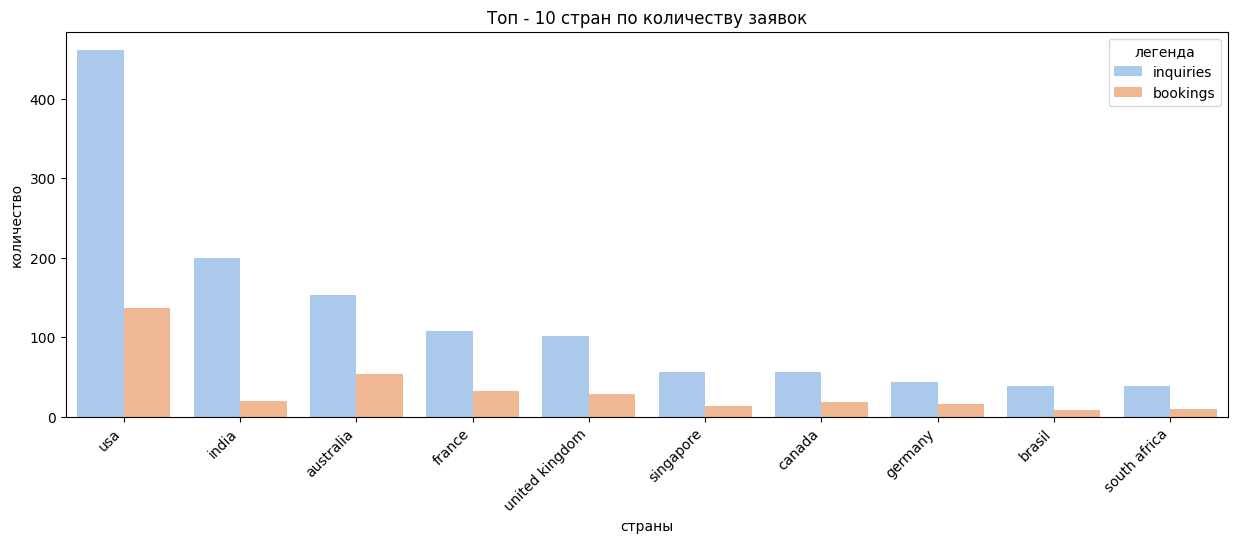

In [47]:
make_barplot(country_group.head(10), 'countries', 'inquiries', 'bookings', 'Топ - 10 стран по количеству заявок', 'страны', 'количество')

Мы видим, что по количеству заявок лидируют США, Индия и Австралия. Однако, на графике видно, что граждане Индии заметно реже подтверждают заказ, по сравнению с многими другими гостями.

Изучим показатели конверсии

### 4.2 Топ 5 стран по показателям конверсии

In [48]:
conv = country_group.sort_values(by = 'share', ascending = False).query('bookings>=20')
conv

,countries,inquiries,bookings,share
2,australia,153,54,0.352941
22,france,108,32,0.296296
83,usa,461,136,0.295011
81,united kingdom,102,29,0.284314
30,india,200,20,0.100000


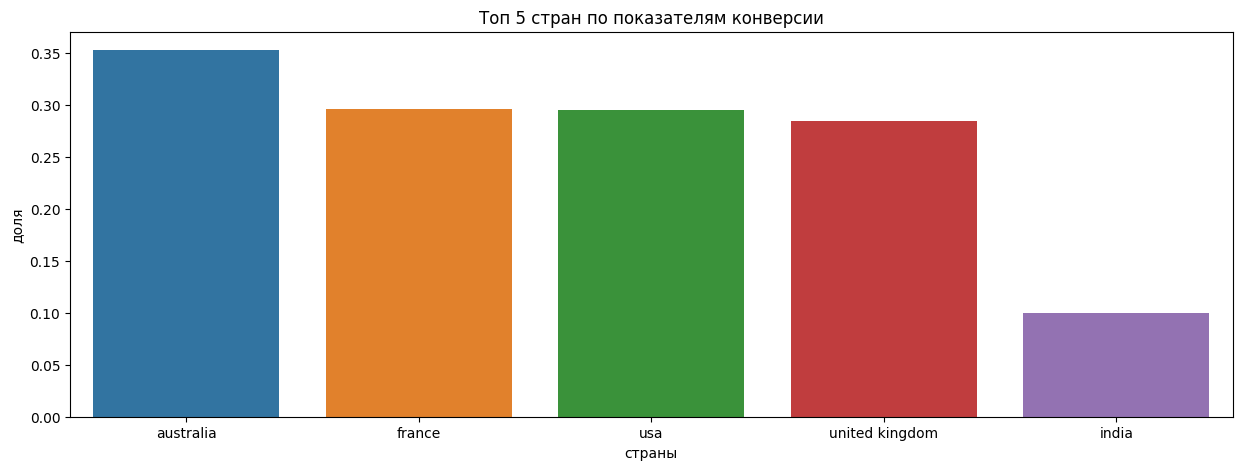

In [49]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data = conv,
    x='countries', y='share').set(title = 'Топ 5 стран по показателям конверсии')
plt.ylabel("доля")
plt.xlabel("страны")
plt.show()

Самые лучшие показатели конверсии у Австралийцев. Примерно 35% человек, сделавших заявку на сайте, впоследствии стали клиентами

Самые низкие показатели конверсии, как мы это ранее наблюдали, у индусов (примерно 10%)

Мы исключили из анализа страны, в которых у нас было слишком мало данных для исследования

### 4.3 Узнаем в какие периоды конверсия выше, а в какие - ниже

In [50]:
df['order_month'] = df['request_time'].dt.month

In [51]:
def months(row):
  return str(int(row['month'])) + '_' + str(int(row['year']))

In [52]:
month_group = df.groupby(['order_year', 'order_month']).agg({'revenue':'sum','booked': ['count', 'sum']}).reset_index()
month_group.columns = ['year', 'month', 'revenue','inquiries', 'bookings']
month_group['share'] = month_group['bookings']/month_group['inquiries']
month_group['arpu'] = month_group['revenue']/month_group['inquiries']
month_group['arppu'] = month_group['revenue']/month_group['bookings']
month_group['month_year'] = month_group.apply(months, axis= 1)


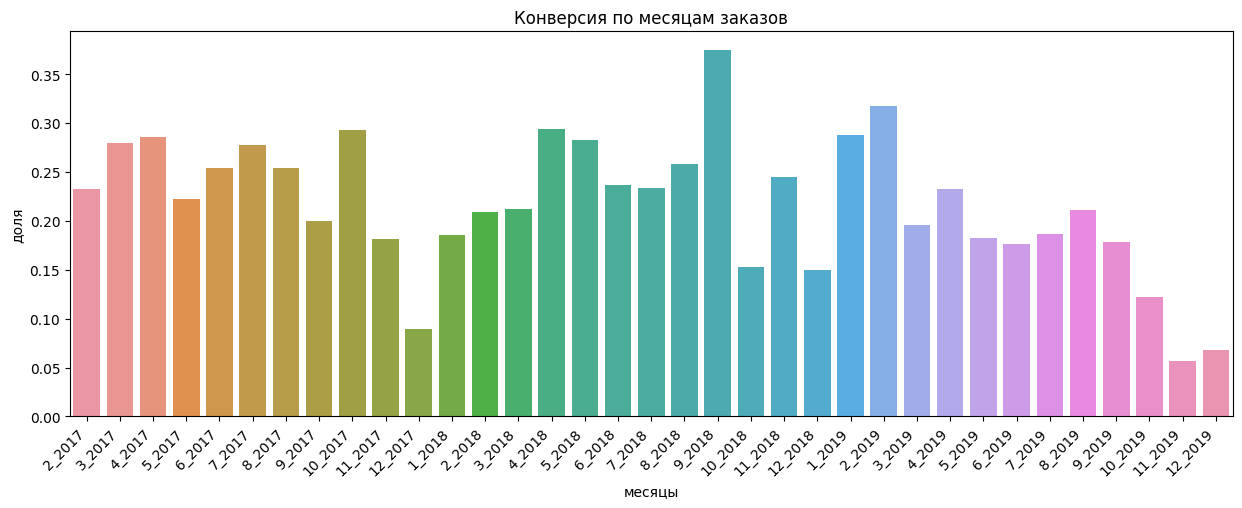

In [53]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data = month_group,
    x='month_year', y='share').set(title = 'Конверсия по месяцам заказов')
plt.ylabel("доля")
plt.xlabel("месяцы")
plt.xticks(rotation=45, ha='right')
plt.show()

Мы видим, что падение конверсии происходит обычно в осенние месяцы.

В 2017 году показатели конверсии начали резко снижаться в ноябре, в 2018 году - в октябре, а в 2019 падение стало заметно уже с сентября. Последние месяцы 2019 года не слишком показательны, так как клиенты, сделавшие заявки, могли планировать приехать в 2020.

Интересно, что в зимние месяцы падает не только общая прибыль, но и конверсия. В ноябре и декабре клиенты обычно делают заказы на январь и фервраль, а это часто самые непопулярные месяцы в году. Но даже те клиенты, которые планируют отдых зимой, почему-то редко подтверждают свои заявки.





Построим сводный график конверсий по месяцам

In [56]:
a = df.loc[df['request_time'] < pd.to_datetime('2019-10-01')]
group2 = a.groupby('order_month').agg({'booked':['count', 'sum']}).reset_index()
group2.columns = ['month', 'count', 'sum']
group2['share'] = group2['sum']/group2['count']
group2 = group2.sort_values(by = 'month')
group2['month'] = group2['month'].astype(str)


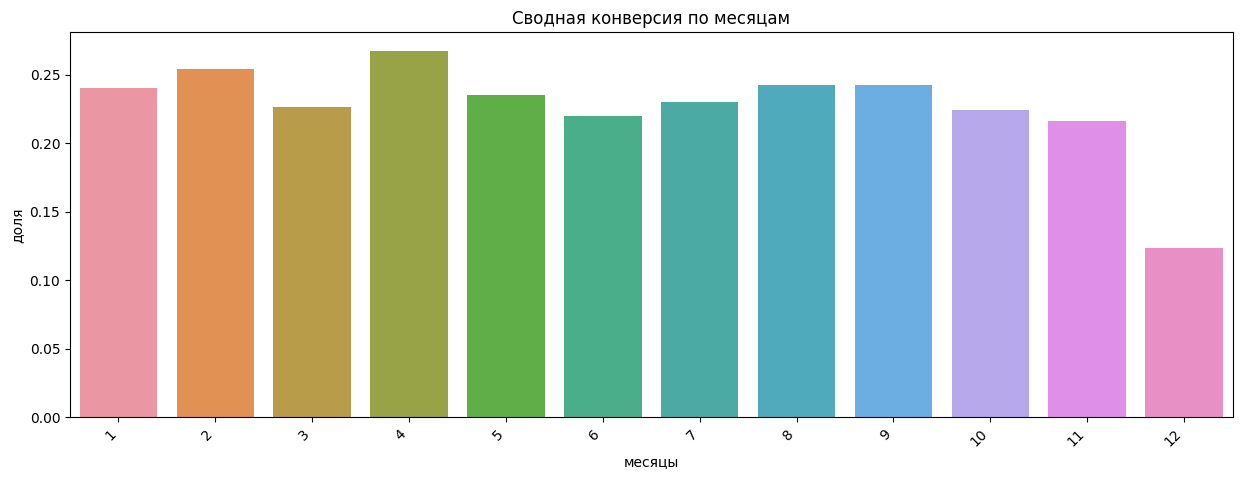

In [55]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data = group2,
    x='month', y='share').set(title = 'Сводная конверсия по месяцам')
plt.ylabel("доля")
plt.xlabel("месяцы")
plt.xticks(rotation=45, ha='right')
plt.show()

На сводном графике мы не видим явно выраженных трендов. Однако, можно явно видеть, что показатели конверсии в декабре заметно ниже, чем в другие месяцы. Мы удалили данные последних трех месяцев 2019 года, так как в противном случае, клиенты, оставившие заявки, просто могли не успеть приехать.


### 4.4 Прибыль копании по месяцам

In [57]:
year_group = df.groupby(['order_year']).agg({'revenue': 'sum'}).reset_index()
year_group.columns = ['year', 'revenue']


In [65]:
def make_two_plots(df1, x1, y1, xlab1, title1, df2, x2, y2, xlab2, title2):
  plt.figure(figsize=(15, 5))
  ax1 = plt.subplot(1, 2, 1)
  sns.barplot(data= df1, x= x1, y=y1, ax = ax1)
  plt.xlabel(xlab1)
  plt.xticks(rotation=50)
  plt.title(title1)

  ax2 = plt.subplot(1, 2, 2)
  sns.barplot(data= df2, x= x2, y=y2,  ax = ax2)
  plt.xlabel(xlab2)
  plt.title(title2)
  plt.xticks(rotation=50)
  plt.tight_layout()
  plt.show()

Сгруппируем данные теперь не по месяцу бронирования тура, а по месяцу самих туров

In [59]:
month_group1 = df.groupby(['year', 'month']).agg({'revenue':'sum','booked': ['count', 'sum']}).reset_index()

In [60]:
month_group1.columns = ['year', 'month', 'revenue','inquiries', 'bookings']
month_group1['share'] = month_group1['bookings']/month_group1['inquiries']
month_group1['arpu'] = month_group1['revenue']/month_group1['inquiries']
month_group1['arppu'] = month_group1['revenue']/month_group1['bookings']
month_group1['month_year'] = month_group1.apply(months, axis= 1)

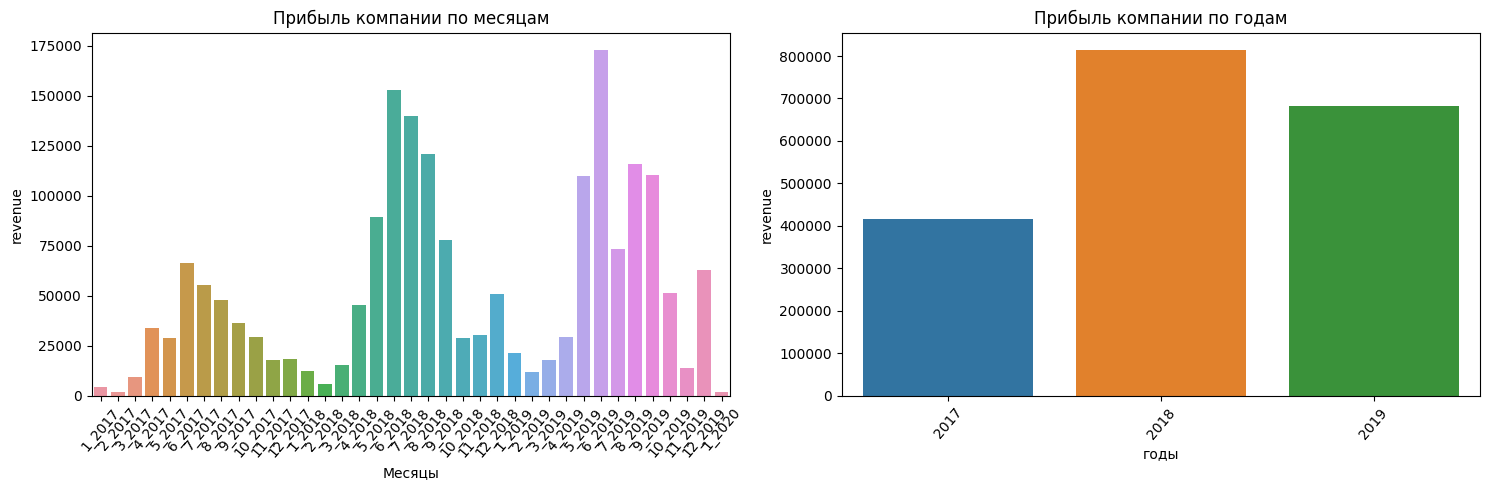

In [66]:
make_two_plots(month_group1, 'month_year', 'revenue', 'Месяцы', 'Прибыль компании по месяцам', year_group, 'year', 'revenue', 'годы', 'Прибыль компании по годам')

График прибыли по месяцам очень явно иллюстрирует сезонность бизнеса. Мы видим пики пребыли и сильное падение поздней осенью c ноября по март.

График прибыли по годам показывает высокие значения прибыли в 2018 году. На такие показатели повлиял чемпионат мира по футболу. Однако, общая прибыль 2019 года выше 2017, так что в целом положительная динамика все-таки присутствует.

### 4.5 ARPU и ARPPU по месяцам

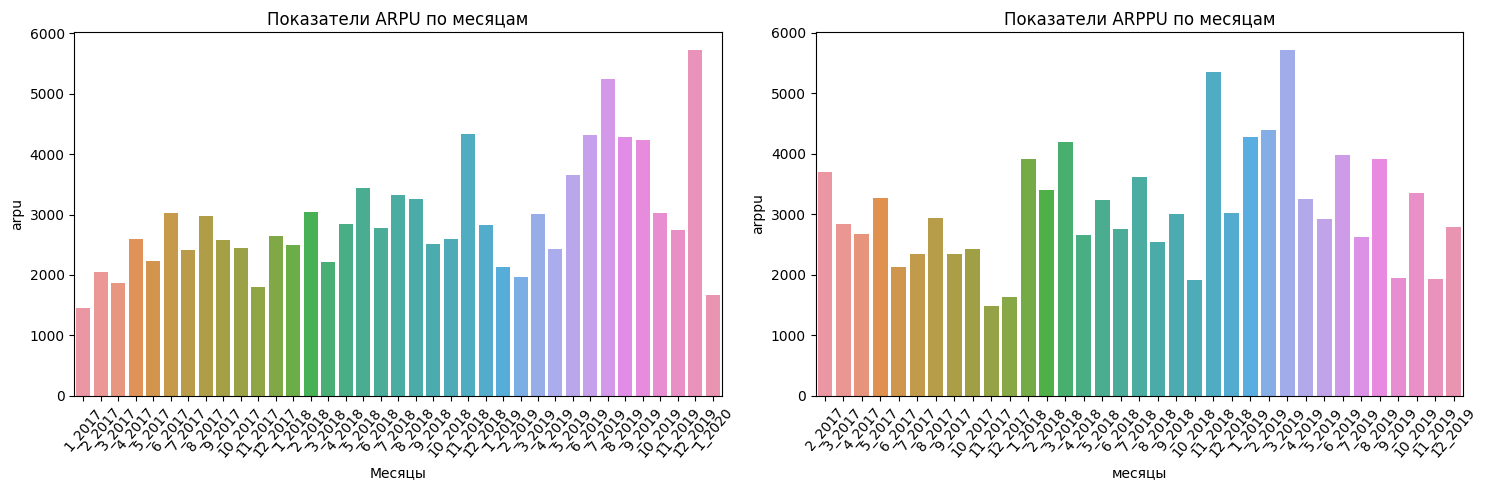

In [67]:
make_two_plots(month_group1, 'month_year', 'arpu', 'Месяцы', 'Показатели ARPU по месяцам', month_group, 'month_year', 'arppu', 'месяцы', 'Показатели ARPPU по месяцам')

Мы ранее наблюдали, что зимой и весной прибыль компании падает. Мы также наблюдали, что и конверсия в осенние месяцы ниже, чем в высокий сезон.(осенью клиенты бронируют зимние туры)

Графики ARPU и ARPPU демонстрирует аналогичные сезонные циклы. Мы видим, что в период низкого сезона даже показатели среднего чека ниже, чем в высокий сезон

### 4.6 Топ стран по показателям ARPPU и ARPU

In [68]:
li = list(conv['countries'])
reven= df.query('(revenue > 0) & (citizenship in @li)')
group5 = reven.groupby('citizenship').agg({'revenue':'mean'}).reset_index()
group5.columns = ['citizenship', 'arppu']
group5 = group5.sort_values(by = 'arppu', ascending = False)
group5

,citizenship,arppu
0,australia,3674.648148
2,india,3548.850000
4,usa,3154.147059
1,france,2971.281250
3,united kingdom,2541.275862


In [69]:
reven1 = df.query('citizenship in @li').copy(deep = True)
reven1['revenue'] = reven1['revenue'].fillna(0)
group6 = reven1.groupby('citizenship').agg({'revenue':'mean'}).reset_index()
group6.columns = ['citizenship', 'arpu']

In [70]:
group7 = group6.merge(group5, on = 'citizenship')
group7

,citizenship,arpu,arppu
0,australia,1296.934641,3674.648148
1,france,880.379630,2971.281250
2,india,354.885000,3548.850000
3,united kingdom,722.519608,2541.275862
4,usa,930.507592,3154.147059


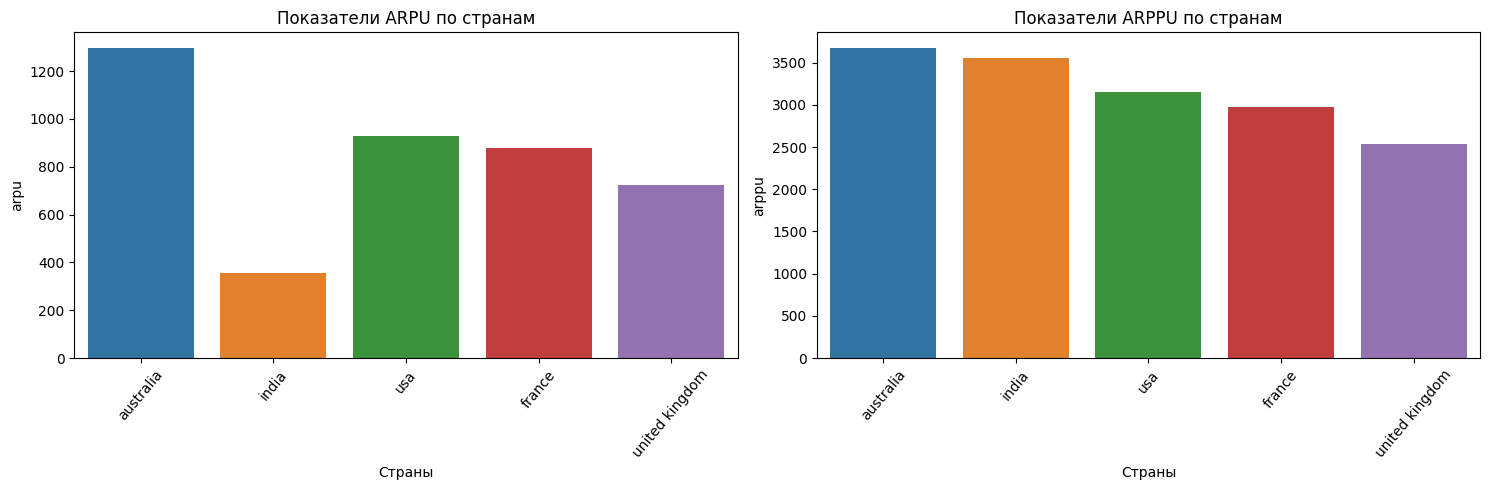

In [71]:
data1 = group7.sort_values(by = 'arppu', ascending = False)
make_two_plots(data1, 'citizenship', 'arpu', 'Страны', 'Показатели ARPU по странам', data1, 'citizenship', 'arppu', 'Страны', 'Показатели ARPPU по странам')

Стоит обратить внимание, что в данном исследовании мы изменили значения прибыли на некоторый коэффициент. По этим графикам мы не можем делать выводы о конкретных значения прибыли на клиента, однако мы можем узнать, клиенты из каких стран приносят больше прибыли компании.

Можно наблюдать, что Австралия лидирует как по показателям ARPPU, так и по показателям ARPU.

Интересно наблюдать показатели по клиентам из Индии. Так, средний чек у клиентов из Индии даже выше, чем у американцев. Однако, показатели конверсии у этих клиентов самые низкие, поэтому и значения ARPU в Индии ниже, чем в других странах

### 4.7 Время для планирования путешествий

Узнаем, насколько заранее путешественники из разных стран начинают планировать свой отдых

In [72]:
df_booked = df.query('booked == 1')
len(df_booked)


601

In [73]:
df_booked= df_booked.rename(columns = {'date':'day'})
df_booked.loc[df_booked.index == 2432, 'day'] = 30
df_booked.loc[df_booked.index == 104, 'day'] = 30

In [74]:
df_booked[['year', 'month', 'day']] = df_booked[['year', 'month', 'day']].astype('int').copy(deep = True)

In [76]:
df_booked['tour_date'] = pd.to_datetime(df_booked[['year', 'month', 'day']])
df_booked['dif'] = (df_booked['tour_date']-df_booked['request_time']).dt.days
df_booked['dif'] = df_booked['dif'].apply(lambda x: x*0 if x < 0 else x)

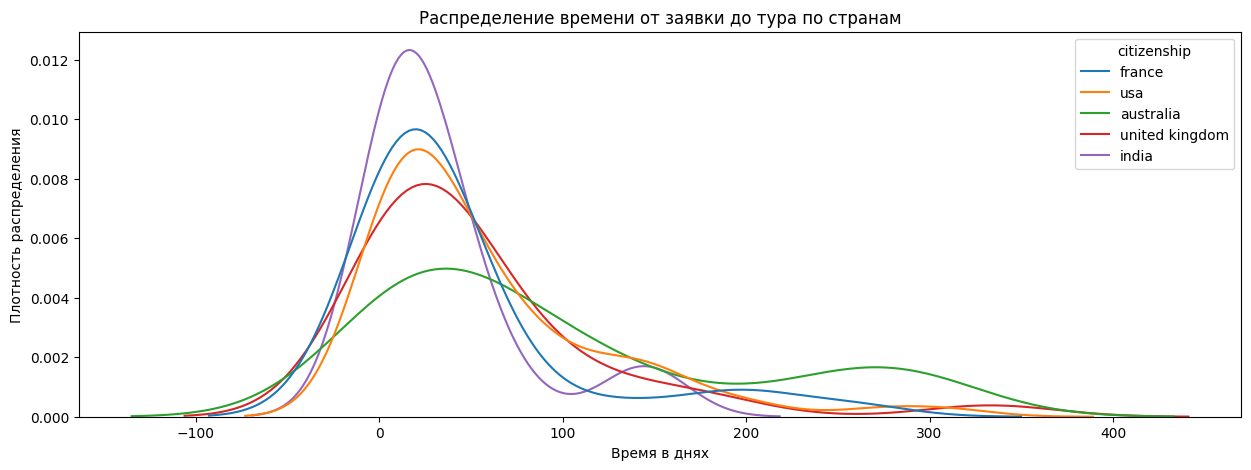

In [77]:
fig,ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(data = df_booked.query('(citizenship in @li)&(dif <400)'), hue= 'citizenship', x = 'dif', common_norm = False).set(title='Распределение времени от заявки до тура по странам')
plt.ylabel("Плотность распределения")
plt.xlabel("Время в днях")
plt.show()

In [82]:
df_test = df_booked.query('(citizenship in @li)&(dif <400)')[['citizenship', 'dif']]

In [85]:
df_unmelted = pd.pivot_table(df_test, index=df_test.index, columns='citizenship', values = 'dif')

In [87]:
df_unmelted.describe()

citizenship,australia,france,india,united kingdom,usa
count,53.000000,32.000000,20.000000,29.000000,135.000000
mean,98.471698,44.093750,33.350000,53.724138,58.088889
std,99.566098,62.606997,42.067959,70.691430,64.976398
min,0.000000,1.000000,0.000000,2.000000,0.000000
25%,20.000000,6.750000,7.500000,12.000000,11.000000
50%,56.000000,22.500000,17.500000,28.000000,33.000000
75%,134.000000,38.250000,40.250000,58.000000,80.500000
max,298.000000,256.000000,149.000000,333.000000,316.000000


На графике видно, что лидируют по времени планирования путешествий  австралийцы. В среднем они оставляют заявку за 56 дней до путешествия, но часто заявки могут приходить за пол года до тураи даже больше.

Путешественники из Индии любят спонтанность. Удивительно, что путешественники из Франции по своему поведению ближе к индусам, чем к австралийцам.

Изучим планирование путешествий на большем массиве данных. Посмотрим на заявки путешественников, которые не забронировали тур, однако оставили информацию о предполагаемой дате путешествия

In [88]:
group_raw = (
          raw1.query('(citizenship != "unknown")& (citizenship != "mixed")')
          .groupby('citizenship').agg({'id':'count','dif':'median'})
          .sort_values(by = 'dif', ascending= False).reset_index().query('id>30')
)

In [89]:
l = list(group_raw['citizenship'])

In [90]:
raw2 = raw1.query('dif > -2').copy(deep = True)
raw2['dif'] = raw2['dif'].apply(lambda x: x*0 if x == -1 else x)

In [93]:
raw2.query('(citizenship in @l)& (dif <400)')

,Unnamed: 0,source,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_choice,citizenship,coming_date,other_request,request_time,id,year,date_come,dif
1,1,http://bridgetomoscow.com/dogsledging-in-the-m...,unknown,522,NaN,NaN,NaN,NaN,usa,currently in moscow,Will you be offering the dog sledding trip aga...,2017-02-11 16:41:38,3508,2017,2017-02-11,0
5,5,http://bridgetomoscow.com/driving-tour-of-moscow,English,NaN,4.0,0.0,0.0,NaN,usa,march 5 - march 8; prefer tour on either march 7,Group of 4 people.<br>,2017-02-14 06:26:53,4301,2017,2017-03-05,18
16,16,http://bridgetomoscow.com/customized-tours,unknown,1,NaN,NaN,NaN,NaN,canada,june 12th - 14th 2017,I&#38;#39;m not sure whether all that I have s...,2017-02-18 11:39:36,1393,2017,2017-06-12,113
17,17,http://bridgetomoscow.com/4-days3-nights-sergi...,unknown,1,NaN,NaN,NaN,NaN,usa,july,Still planning my prospective Russia trip. Ju...,2017-02-18 19:04:25,3625,2017,2017-07-15,146
19,19,http://bridgetomoscow.com/4-days3-nights-sergi...,unknown,2,NaN,NaN,NaN,NaN,canada,departure 25 august 2017 up to 29 august ...,better in french<br>,2017-02-18 23:45:11,3734,2017,2017-08-25,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142,6143,https://bridgetomoscow.com/2-days1-night-vladi...,unknown,3,NaN,NaN,NaN,NaN,india,30th april,<br>,2023-04-28 17:25:09,4216,2023,2023-04-30,1
6143,6144,https://bridgetomoscow.com/2-days1-night-sergi...,unknown,3,NaN,NaN,NaN,NaN,india,30th april,<br>,2023-04-28 17:26:04,4216,2023,2023-04-30,1
6144,6145,https://bridgetomoscow.com/2-days1-night-sergi...,unknown,3,NaN,NaN,NaN,NaN,india,30th april,<br>,2023-04-28 17:26:24,4216,2023,2023-04-30,1
6173,6174,https://bridgetomoscow.com/catherine-palace-tour,unknown,1,NaN,NaN,NaN,NaN,singapore,5th june 2023,Do you have fixed group tours to the Catherine...,2023-05-25 05:02:13,1485,2023,2023-06-05,10


In [94]:
median_order = raw2.query('(citizenship in @l)& (dif <400)').groupby('citizenship')['dif'].median().sort_values().index

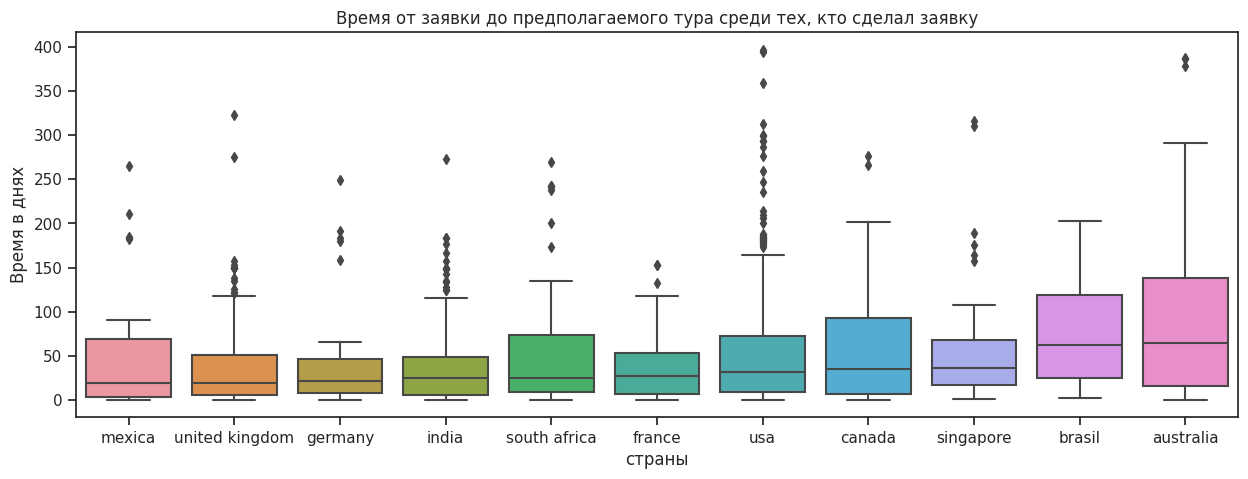

In [95]:
plt.figure(figsize=(15, 5))
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=raw2.query('(citizenship in @l)& (dif <400)'), x= 'citizenship', y='dif', order=median_order).set(title='Время от заявки до предполагаемого тура среди тех, кто сделал заявку')
plt.ylabel('Время в днях')
plt.xlabel('страны')
plt.show()

Мы видим, что лидеры по долгосрочному планированию  - австралийцы и бразильцы. А вот в конце списка оказались, как ни странно, не индусы, а европейцы (туристы из Германии и Великобритании) и Мексиканцы

Так, средний австралиец обычно планирует путешествие за 64 дня, в то время как средний англичанин или немец оставляет заявку за 19-20 дней

### 4.8 Топ 10 страниц по частоте заявок

In [96]:
raw['page'] = raw['source'].apply(lambda x: x[27:])
raw['page'] = raw['page'].apply(lambda x: 'f'+ x if x == 'eedback' else x)
raw['page'] = raw['page'].apply(lambda x: x.replace('ustomized-tours', 'customized-tours') if x == 'ustomized-tours' else x)
raw_page = raw[~raw['source'].str.contains('upcoming', case=False)]
list_raw = ['bolshoi-backstage-tour','bolshoi-backstage-tour', 'dogsledding-in-the-moscow-countryside', 'grand-kremlin-palace', 'troika-rides', 'dogsledging-in-the-moscow-countryside', 'grand-kremlin-palace']
raw_page = raw_page.query('page not in @list_raw')

In [98]:
raw_page.sample()

,Unnamed: 0,source,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_choice,citizenship,coming_date,other_request,request_time,id,year,date_come,page
5613,5614,https://bridgetomoscow.com/1-day-sergiev-posad,English,NaN,1.0,0.0,0.0,Option 1 (by car);,usa,"september 25, 2021",<br>,2021-09-19 14:39:07,2981,2021,2021-9-25,1-day-sergiev-posad


In [110]:
raw_page.groupby('page').agg({'source':'count'}).sort_values(by = 'source', ascending = False).rename(columns = {'source':'количесвто закзаов'}).head(10)

,количесвто закзаов
page,
feedback,1071
customized-tours,471
moscow-in-1-day,156
1-day-vladimir-and-suzdal-by-train,144
moscow-food-tour,100
moscow-in-23-days,84
star-city,70
3-days2-nights-sergiev-posad-rostov-yaroslavl-kostroma-suzdal-vladimir,59
walking-tour-of-moscow,59


### 4.9 Показатели конверсии для страниц сайта

Мы исправим написание некоторых страниц, а также сократим название некоторых url сайта, чтобы их удобнее было анализировать.

Мы также удалили из анализа некоторые страницы, которые продавали групповые туры и обслуживались менеджером по групповым турам. В нашем исследовании мы изучаем заказы индивидуальных клиентов.

In [111]:
df_page= df.copy(deep = True)
df_page['page'] = df_page['page'].apply(lambda x: x[1:] if x[0] == '/' else x)
df_page['page'] = df_page['page'].str.replace('feedback /feedback', 'feedback')
df_page.sample(3)

,Unnamed: 0,id,order_year,language,travellers_number,travellers_adults,travellers_teens,travellers_babies,tour_cost,page,request_time,citizenship,year,month,date,tour days,city,revenue,booked,order_month
85,85,1479,2017,unknown,NaN,NaN,NaN,NaN,0.0,feedback,2017-10-23 14:09:28,unknown,NaN,NaN,NaN,NaN,NaN,NaN,0,10
2681,2685,928,2019,English,NaN,1.0,0.0,0.0,8150.0,walking-tour-of-moscow,2019-02-05 11:04:00,malta,2019.0,2.0,18.0,1.0,0,1247.0,1,2
901,903,1488,2018,unknown,7,NaN,NaN,NaN,0.0,one-day-tour-of-st-petersburg /wonders-under-o...,2018-06-08 02:54:24,india,NaN,NaN,NaN,NaN,NaN,NaN,0,6


In [112]:
page_group = df_page.groupby('page').agg({'id':'count', 'booked':'sum'}).sort_values(by = 'id', ascending = False).reset_index().head(26)
page_group['share'] = page_group['booked']/page_group['id']
searchfor = ['bolsh', 'dogsled', 'grand']
for x in searchfor:
  page_group  = page_group[~page_group['page'].str.contains(x)]

In [113]:
list1 = ['feedback','customized-tours','1-day-golden_ring','moscow-in-1-day ','moscow-food-tour','moscow-in-2-3-days','3-days_suzdal-vladimir',
 'jewish-moscow-tour','star-city','2-days_bogolyubovo-vladimir','layover-tours ','vodka-museum-tour','2-days_suzdal-vladimir ','the-tour-of-moscow-kremlin',
 'soviet-tour-of-moscow','driving-tour-of-moscow','4-days-murmansk','ghost-tour-of-moscow ','4-days_golden_ring','1-day-sergiev-posad','walking-tour-of-moscow',
 'troika-rides']

In [114]:
page_group['page1'] = list1


In [115]:
page_g = page_group.sort_values(by = 'share', ascending = False).query('id>20')

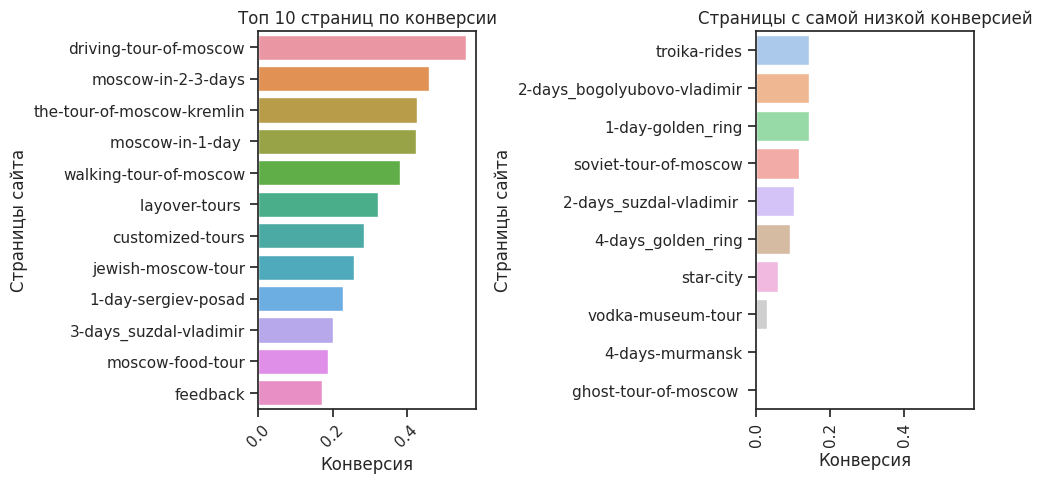

In [117]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data= page_g.head(12), x= 'share', y= 'page1', ax = ax1)
plt.xticks(rotation=45)
plt.title("Топ 10 страниц по конверсии")
plt.ylabel("Страницы сайта")
plt.xlabel("Конверсия")

ax2 = plt.subplot(1, 2, 2, sharex=ax1)
sns.barplot(data= page_g.tail(10), x= 'share', y= 'page1', ax = ax2)
plt.title('Страницы с самой низкой конверсией')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel("Страницы сайта")
plt.xlabel("Конверсия")
plt.show()



Топ страниц, с которых клиенты оставляли заявки - 'feedback','customized-tours', 'moscow-in-1-day','1-day-vladimir-and-suzdal-by-train', 'moscow-food-tour','moscow-in-23-days', 'star-city','3-days2-nights-sergiev-posad-rostov-yaroslavl-kostroma-suzdal-vladimir','walking-tour-of-moscow', 'the-tour-of-moscow-kremlin'. При этом страница 'feedback' - лидирует с большим отрывом. Эта страница для любых общих вопросов, где можно не заполняя форму описать свои пожелания.

Лидеры по конверсии - страницы с Московскими турами с встроенным калькулятором. Люди уже на сайте видят цену и не будут оставлять заявку, если цена их не устраивает.

Страницы с наиболее низкой конверсией ( я анализировала не всю историю, а достаточно популярные страницы, с которых поступало не менее 20 заявок) - это достаточно дорогие туры. На страницах не была опубликована цена и многие клиенты уходили, узнав цену от менеджера.

### 4.10 Страницы, принесшие больше всего прибыли компании

In [118]:
page_profit = df_page.groupby('page').agg({'revenue':'sum'}).reset_index().sort_values(by = 'revenue', ascending = False).head(10)


In [121]:
page_profit

,page,revenue
163,feedback,352626.0
108,customized-tours,322380.0
268,moscow-in-1-day,105292.0
286,moscow-in-23-days,82918.0
53,3-days2-nights-sergiev-posad-rostov-yaroslavl-...,64749.0
7,1-day-vladimir-and-suzdal-by-train,41652.0
65,4-days3-nights-sergiev-posad-rostov-yaroslavl-...,40768.0
204,fr/feedback,38477.0
35,2-days1-night-sergiev-posadsuzdal-bogolyubovo-...,31823.0
74,4-days3-nights-vladimirbogolyubovo-suzdalkostr...,31574.0


In [119]:
list2 = ['feedback','customized-tours','moscow-in-1-day ', 'moscow-in-2-3-days','3-days_suzdal-vladimir', '1-day-golden_ring', '4-days_golden_ring', 'fr/feedback', '2-days_bogolyubovo-vladimir', '4-days_golden_ring1']


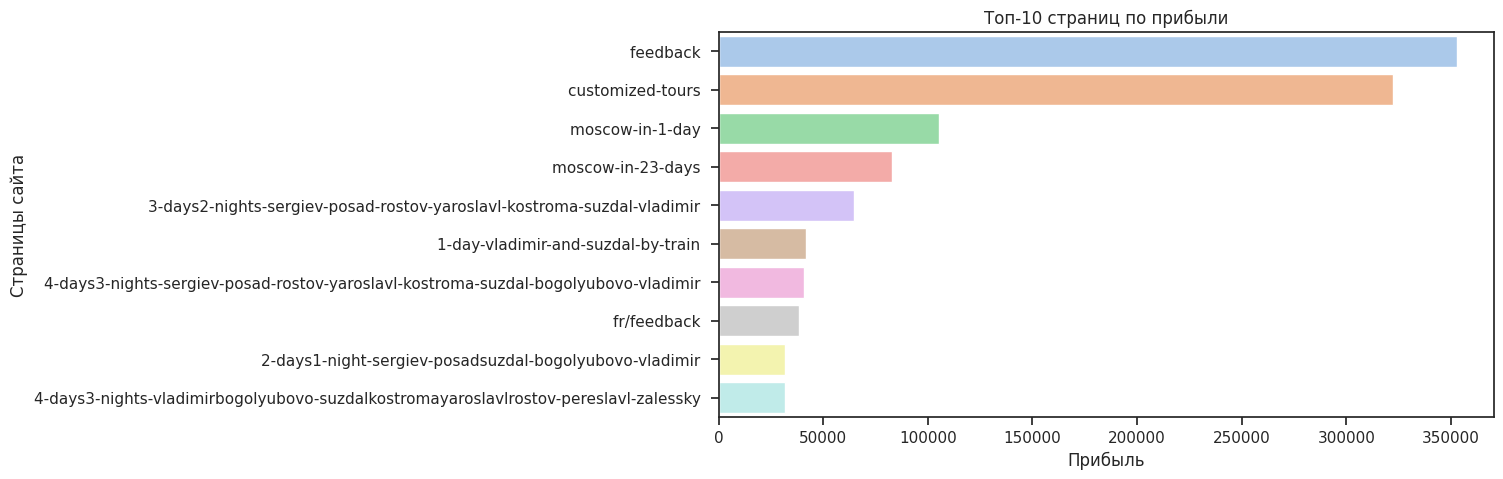

In [123]:
plt.figure(figsize=(10, 5))
sns.barplot(data= page_profit, x= 'revenue', y= 'page',palette = 'pastel')
plt.title('Топ-10 страниц по прибыли')
plt.ylabel("Страницы сайта")
plt.xlabel("Прибыль")
plt.show()

С большим отрывом лидируют страницы, по которым компания получала больше всего заявок - 'feedback' и 'customised tours'

Стоит отметить, что страницы с низкими показателями конверсии (страницы разных туров Золотого кольца), также попали в топ-10 страниц по прибыли

## Выводы и наблюдения

1. Больше всего заказов компания получила из стран  США, Индии и Австралия

2. Самые лучшие показатели конверсии у Австралийцев. Примерно 35% человек, сделавших заявку на сайте, впоследствии стали клиентами. Самые низкие показатели конверсии у индусов (примерно 10%).

3. Можно наблюдать, что Австралия лидирует как по показателям ARPPU, так и по показателям ARPU. Интересно наблюдать показатели по клиентам из Индии. Так, средний чек у клиентов из Индии даже выше, чем у американцев. Однако, показатели конверсии у этих клиентов самые низкие, поэтому и значения ARPU в Индии ниже, чем в других странах. Мы бы рекоммендовали компании искать пути лучшего взаимодействия с клиентами из Индии: в компании много заявок из этой страны, и средний чек достаточно высокий. Нужно найти способ улучшить конверсию.

4.  Мы изучили динамику прибыли компании по месяцам, а также динамику конверсии. График прибыли очень явно иллюстрирует сезонность бизнеса. Мы видим пики прибыли и сильное падение поздней осенью и зимой. Самая нзкая конверсия наступает чуть раньше. (Самая низкая конверсия в декабре, а а самые низкие показатели прибыли в январе и феврале.)

Мы бы рекоммендовали компании увеличить ассортимент зимних туров, а также составить конкурентные предложения на рынке. Мы выявили проблему не только падения спроса,но и падения конверсии. Клиенты, оставившие заявку в декабре, редко подтверждают бронирования, и с этой проблемой стоит поработать.

5. Мы видим, что  лидируют по времени планирования путешествий - австралийцы. В среднем они оставляют заявку за 56 дней до путешествия, но часто заявки могут приходить за пол года до тура и даже больше.
Путешественники из Индии любят спонтанность. Удивительно, что путешественники из Франции  и Германии по своему поведению ближе к индусам, чем к австралийцам.

6. Мы нашли топ страниц по популярности, а также страницы, которые принесли компании наибольшую прибыль.
Мы также проанализировали страницы с наилучшими и наихудшими показателями конверсии. Стоит обратить внимание, что лидеры по конверсии - страницы с Московскими турами с встроенным калькулятором. Люди уже на сайте видят цену и не будут оставлять заявку, если цена их не устраивает.  Страницы с наиболее низкой конверсией - достаточно дорогие туры, на которых не была  опубликована цена. Возможно, компании стоит задуматься о добавлении встроенного калькулятора на эти страницы.

7. Самый популярные страница  по количеству заявок и по прибыли — это страницы feedback и customised tours.
Feedback - эта страница для любых общих вопросов, где можно не заполняя форму описать свои пожелания.
customised tours – это страница, на которой клиенты могут сформировать заявку, выбрав наиболее интересные достопримечательности.
Обе страницы не могут лидировать по конверсии, так как на них не опубликована цена, однако именно эти страницы помогают большинству клиентов компании сформировать заявку по уникальному индивидуальному запросу.
